In [ ]:
!pip install pytorch-complex
import torchcomplex
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.utils import make_grid
import os
import random
import numpy as np
import pandas as pd
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, jaccard_similarity_score
from google.colab import drive

     |████████████████████████████████| 42 kB 438 kB/s 


In [ ]:
!nvidia-smi

Thu Jun 24 11:56:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
drive.mount('/content/drive')

In [ ]:
training_data = pickle.load(open('/content/drive/My Drive/trainingData.pickle', 'rb'))

In [ ]:
Xt = []
yt = []
features = None
labels = None
label = []

In [ ]:
for features,labels in training_data:
  Xt.append(features)
  yt.append(labels)

In [ ]:
a = np.array(Xt)
b = np.array(yt)
type(a)

numpy.ndarray

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(a, b, test_size=0.25, shuffle=True)  # 70% training, 25% testing

In [ ]:
print("Xtrain data shape",X_train.shape)
print("YTrain data shape",y_train.shape)

Xtrain data shape (2298, 512, 512, 3)
YTrain data shape (2298,)


(<matplotlib.axes._subplots.AxesSubplot at 0x7f04dbbfd390>,
 <matplotlib.image.AxesImage at 0x7f04dbbbca10>)

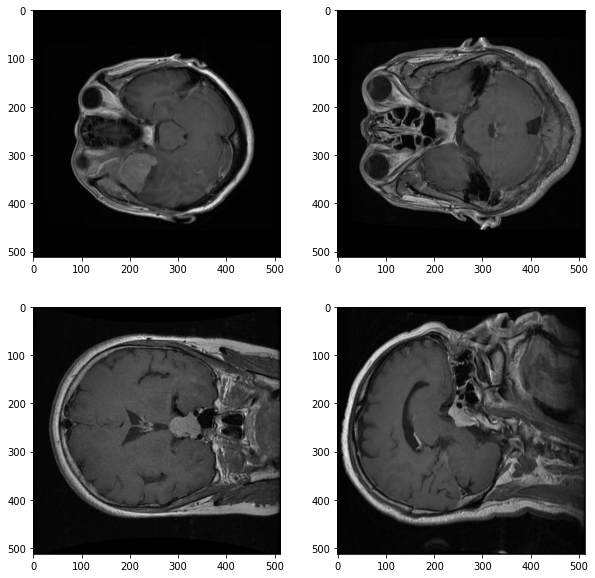

In [ ]:
# visualizing images
i = 0
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(X_train[i], cmap='gray')
plt.subplot(222), plt.imshow(X_train[i+30], cmap='gray')
plt.subplot(223), plt.imshow(X_train[i+50], cmap='gray')
plt.subplot(224), plt.imshow(X_train[i+100], cmap='gray')

In [ ]:
X_train[1].shape

(512, 512, 3)

In [ ]:
class RealCNNData(Dataset):
  def __init__(self, images, labels):
    # images
    self.X = images
    # labels
    self.y = labels
    #Coverts numpy arary tro tensor and normalizes
    self.tran = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

  def __len__(self):
    # return length of image samples
    return len(self.X)

  def __getitem__(self, idx):
    # perform transformations on one instance of X
    # numpy array as a tensor
    data = self.tran(self.X[idx])
    
    # store the transformed images in a list
    new_batch = [data]

    # one-hot encode the labels
    labels = torch.zeros(4, dtype=torch.float32)
    labels[int(self.y[idx])] = 1.0
    #labels = self.y[idx]
    new_labels = [labels]
    
    # Images and corresponding labels per sample will be returned
    return (torch.stack(new_labels), torch.stack(new_batch))

In [ ]:
Xt = None
yt = None
features = None
labels = None
label = None
training_data = None
a = None
b = None

In [ ]:
train_set = RealCNNData(X_train, y_train)
test_set = RealCNNData(X_test, y_test)

In [ ]:
print(f"Number of training samples: {len(X_train)}")
print(f"Number of testing samples: {len(X_test)}")

Number of training samples: 2298
Number of testing samples: 766


In [ ]:
train_gen = DataLoader(train_set, batch_size=4, shuffle=True, pin_memory=True, num_workers=8)
test_gen = DataLoader(test_set, batch_size=4, shuffle=True, pin_memory=True, num_workers=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class CnnNet(nn.Module):
    
    def __init__(self):
        super(CnnNet, self).__init__()
        self.conv1 = nn.Conv2d(3,64,5)
        self.bn  = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 16, 5)
        self.fc1 = nn.Linear(16*125*125, 1000)
        self.fc2 = nn.Linear(1000, 100)
             
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1,16*125*125)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = x.abs()
        x =  F.log_softmax(x, dim=1)
        return x

In [ ]:
device = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# defining the model
cmodel = CnnNet().to(device)  
print(cmodel)

CnnNet(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=250000, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=100, bias=True)
)


In [ ]:
# loss function
# if GPU is available set loss function to use GPU
criterion = nn.CrossEntropyLoss().to(device)

# optimizer
optimizer = torch.optim.SGD(cmodel.parameters(), lr=3e-4, momentum=0.9)

# number of training iterations
epochs = 30

# empty lists to store losses and accuracies
train_losses = []
test_losses = []
train_correct = []
test_correct = []

In [ ]:
def save_checkpoint(state, is_best, filename='/content/drive/My Drive/bt_realCnn_ckpt_v2.pth.tar'):
    torch.save(state, filename)

In [ ]:
# set training start time
start_time = time.time()

# set best_prec loss value as 2 for checkpoint threshold
best_prec1 = 2

# empty batch variables
b = None
train_b = None
test_b = None

# start training
for i in range(epochs):
    # empty training correct and test correct counter as 0 during every iteration
    trn_corr = 0
    tst_corr = 0
    
    # set epoch's starting time
    e_start = time.time()
    
    # train in batches
    for b, (y, X) in enumerate(train_set):
        # set label as cuda if device is cuda
        X, y = X.to(device), y.to(device)
        # forward pass image sample
        y_pred = cmodel(X.view(-1, 3, 512, 512))
        # calculate loss
        loss = criterion(y_pred.float(), torch.argmax(y.view(1,4), dim=1).long())

        # get argmax of predicted tensor, which is our label
        predicted = torch.argmax(y_pred, dim=1).data
        # if predicted label is correct as true label, calculate the sum for samples
        batch_corr = (predicted == torch.argmax(y.view(1, 4), dim=1)).sum()
        # increment train correct with correcly predicted labels per batch
        trn_corr += batch_corr
        
        # set optimizer gradients to zero
        optimizer.zero_grad()
        # back propagate with loss
        loss.backward()
        # perform optimizer step
        optimizer.step()

    # set epoch's end time
    e_end = time.time()
    # print training metrics
    print(f'Epoch {(i+1)} Batch {(b+1)*1}\nAccuracy: {trn_corr.item()*100/(len(train_set)):2.2f} %  Loss: {loss.item():2.4f}  Duration: {((e_end-e_start)/60):.2f} minutes') # 4 images per batch * 8 augmentations per image * batch length

    # some metrics storage for visualization
    train_b = b
    train_losses.append(loss)
    train_correct.append(trn_corr)

    X, y = None, None

    # validate using validation generator
    # do not perform any gradient updates while validation
    with torch.no_grad():
        for b, (y, X) in enumerate(test_set):
            # set label as cuda if device is cuda
            X, y = X.to(device), y.to(device)
            #print(y.shape)
            # forward pass image
            y_val = cmodel(X.view(-1, 3, 512, 512))

            # get argmax of predicted tensor, which is our label
            predicted = torch.argmax(y_val, dim=1).data

            # increment test correct with correcly predicted labels per batch
            tst_corr += (predicted == torch.argmax(y.view(1, 4), dim=1)).sum()

    # get loss of validation set
    loss = criterion(y_val.float(), torch.argmax(y.view(1, 4), dim=1).long())
    # print validation metrics
    print(f'Validation Accuracy {tst_corr.item()*100/(len(test_set)):2.2f} Validation Loss: {loss.item():2.4f}\n')

    # if current validation loss is less than previous iteration's validatin loss create and save a checkpoint
    is_best = loss < best_prec1
    best_prec1 = min(loss, best_prec1)
    save_checkpoint({
            'epoch': i + 1,
            'state_dict': cmodel.state_dict(),
            'best_prec1': best_prec1,
        }, is_best)

    # some metrics storage for visualization
    test_b  = b
    test_losses.append(loss)
    test_correct.append(tst_corr)

# set total training's end time
end_time = time.time() - start_time    

# print training summary
print("\nTraining Duration {:.2f} minutes".format(end_time/60))
print("GPU memory used : {} kb".format(torch.cuda.memory_allocated()))
print("GPU memory cached : {} kb".format(torch.cuda.memory_cached()))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1 Batch 2298
Accuracy: 65.10 %  Loss: 1.4590  Duration: 1.53 minutes
Validation Accuracy 76.24 Validation Loss: 0.7266

Epoch 2 Batch 2298
Accuracy: 81.20 %  Loss: 0.0590  Duration: 1.52 minutes
Validation Accuracy 80.55 Validation Loss: 1.1269

Epoch 3 Batch 2298
Accuracy: 92.73 %  Loss: 0.0001  Duration: 1.52 minutes
Validation Accuracy 80.29 Validation Loss: 0.5063

Epoch 4 Batch 2298
Accuracy: 96.87 %  Loss: 0.0000  Duration: 1.52 minutes
Validation Accuracy 85.90 Validation Loss: 0.0028

Epoch 5 Batch 2298
Accuracy: 98.09 %  Loss: 0.0000  Duration: 1.52 minutes
Validation Accuracy 82.64 Validation Loss: 0.0003

Epoch 6 Batch 2298
Accuracy: 98.83 %  Loss: 0.0000  Duration: 1.52 minutes
Validation Accuracy 86.29 Validation Loss: 0.0583

Epoch 7 Batch 2298
Accuracy: 98.48 %  Loss: 0.0000  Duration: 1.52 minutes
Validation Accuracy 84.20 Validation Loss: 0.0000

Epoch 8 Batch 2298
Accuracy: 99.04 %  Loss: 0.0000  Duration: 1.52 minutes
Validation Accuracy 86.55 Validation Loss: 

/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


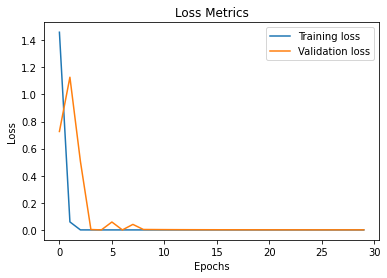

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss Metrics')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

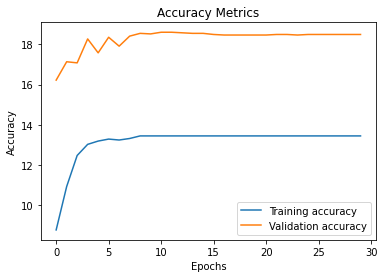

In [ ]:
plt.plot([t/171 for t in train_correct], label='Training accuracy')
plt.plot([t/36 for t in test_correct], label='Validation accuracy')
plt.title('Accuracy Metrics')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()